#안녕하세요.
2024.01.24 시작하도록 하겠습니다.


가장 먼저 할 일은 Dataset 을 다루는 법 입니다.

먼저 Colab의 코드를 이용하여 Cloud 시스템 안에 저장된 데이터를 확인할 수 있습니다.

# 드라이브 내 데이터 가져오기

In [ ]:
 # 코렙 드라이브 마운트 - 개인 드라이브 마운트 됨
from google.colab import drive
drive.mount("/content/drive/")

마운트 된 Colab-Cloud 간에 현재 위치는 우측 아이콘을 통해 확인 할 수 있습니다.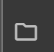

현재 위치를 명확히 하기 위해서는 os 모듈을 사용해야 합니다. os.getcwd 는 위치를 찾는 것이고 os.chdir 은 위치로 이동하는 것을 확인 할 수 있습니다.

In [ ]:
import os
os.getcwd()

In [ ]:
os.chdir('/content/drive')
os.getcwd()

위 코드를 이용하여 적절한 위치를 선택한 후 데이터를 업로드 해봅시다.

이 부분은 코드를 이용해도 좋고 직접 올리셔도 좋습니다.

Colab에서는 권한 문제로 인하여 해당 부분은 content 내에서만 가능합니다.

드라이브 자체에 올리는 방향과 우측 폴더 아이콘을 이용하는 방법은 상관이 없습니다.

In [ ]:
os.chdir('/content')
os.getcwd()

In [ ]:
from google.colab import files  # 코렙 업로드
file_uploaded = files.upload()

In [ ]:
for fn in file_uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(file_uploaded[fn])))

In [ ]:
import pandas as pd #데이터를 읽기 위한 pandas 모듈 적용
import matplotlib.pyplot as plt #데이터 표현을 위한 그래프 lib 적용

In [ ]:
data = pd.read_csv('파일명') #데이터 읽기

고속 데이터 종류의 파일을 읽게되면 이를 표현해보는 것이 필요합니다. 일단 데이터 표현을 먼저 해봅시다.
먼저 데이터의 Head 를 확인해보고
축으로 표현하게 되면 다음과 같이 코드를 작성할 수 있습니다

In [ ]:
data.head()

In [ ]:
x = [i for i in range(5000)]
plt.figure(figsize=(20, 5))
plt.plot(x, data['signal'][:5000])
plt.show()

푸리에 해석은 continuous time domain과 discrete time domain으로 나눌 수 있으며, 신호를 A/D 변환하여 discrete time domain에서 분석을 하는 것입니다. 라이브러리에서 DFT 등을 표현할 수 있으니 확인이 필요합니다.

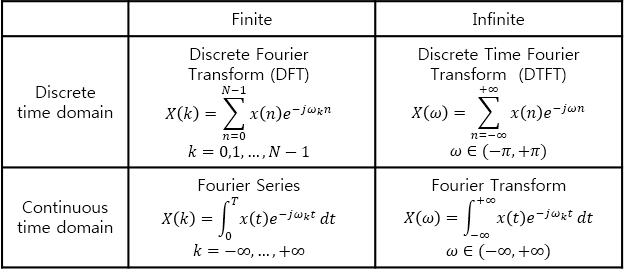

단순 퓨리에 변환을 해보도록 하겠습니다.

In [ ]:
import numpy as np

fft = np.fft.fft(data['signal'][:5000])

# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft)

# 초당 샘플 개수
fs = len(data)
nfft = 50
sr = fs/nfft

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은
#대칭구조로 나와서 high frequency 부분 절반을 날려고
#앞쪽 절반만 사용한다.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=(20,5))
plt.title("Power spectrum")
plt.plot(left_f, left_spectrum)
plt.ylabel("Magnitude")

다음은 FFT 분석을 기반으로 한 STFT 이미지 변환 과정입니다. 해당 내용을 기반으로 한장의 STFT Spectrogram 을 확인할 수 있습니다.

In [ ]:
sig = np.array(data['signal'][600000:900000]) # 3분
sig2 = np.array(data['signal'][900000:1200000]) # 4분

fs = 5000
nfft = 50
sr = fs/nfft

# STFT -> spectrogram
hop_length = 4690  # 얼마나 겹칠 것인가
n_fft = 199  # 윈도우의 길이???

# STFT
stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)
stft2 = librosa.stft(sig2, n_fft=n_fft, hop_length=hop_length)

# 복소공간 값 절댓값 취하기
magnitude = np.abs(stft)
magnitude2 = np.abs(stft2)

# magnitude > Decibels
log_spectrogram = librosa.amplitude_to_db(magnitude)
log_spectrogram2 = librosa.amplitude_to_db(magnitude2)

# display spectrogram
plt.figure(figsize=(10,4))
plt.suptitle("STFT")
plt.subplot(1, 2, 1)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.ylabel("Frequency")
plt.xlabel("Time")
plt.subplot(1, 2, 2)
librosa.display.specshow(log_spectrogram2, sr=sr, hop_length=hop_length)
plt.ylabel("Frequency")
plt.xlabel("Time")
# plt.colorbar(format="%+2.0f")


다음은 모든 데이터를 STFT 로 변환하는 코드입니다. 다음을 잘 활용하면 모든 데이터를 STFT 이미지로 변환할 수 있습니다.

In [ ]:

from scipy.signal import stft

input_folder = '인풋풀더명'
output_folder = '출력폴더명'

file_list = os.listdir(input_folder)

for file_name in file_list:
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_folder, file_name)
        data = pd.read_csv(file_path)
        fs = 5000
        nperseg = 64
        noverlap = nperseg//2
        nfft = nperseg

        signal = data['moter2_z']
        f, t, Zxx = stft(signal, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

        plt.figure()
        plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.abs(Zxx).max(), shading='auto', cmap='jet')

        output_file_name = os.path.splitext(file_name)[0] + '.png'
        output_file_path = os.path.join(output_folder, output_file_name)
        plt.savefig(output_file_path)

        plt.close()